In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Replace with actual dataset path

# ✅ Handle Missing Values using Imputation
imputer_X = SimpleImputer(strategy="mean")  # Impute missing feature values with mean
imputer_y = SimpleImputer(strategy="median")  # Use median for robustness in target

# Separate Features and Target
features = ["month", "year", "latitude", "longitude", "Price", "precipitation", "goldsteinscore"]
target = "individuals"

X = df[features].values
y = df[[target]].values  # Keep as 2D array for imputation

# Apply Imputation
X = imputer_X.fit_transform(X)
y = imputer_y.fit_transform(y).flatten()

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Improved LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()  # Ensures non-negative output while allowing flexibility
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Adjust input for LSTM
        lstm_out = torch.mean(lstm_out, dim=1)  # Mean pooling over all time steps
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 200
num_layers = 2
output_size = 1
num_epochs = 300  # Increased number of epochs
learning_rate = 1e-5  # Lower learning rate

# ✅ Initialize Model, Loss, Optimizer
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))  # Ensure correct shape
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Predict Next 2 Years (24 Months)
future_months = 24
X_future = np.copy(X_test)

# Set correct starting month and year
start_month = 7  # July
start_year = 2024

for i in range(future_months):
    month = (start_month + i - 1) % 12 + 1
    year = start_year + (start_month + i - 1) // 12

    X_future[:, 0] = month  # Update month
    X_future[:, 1] = year   # Update year
    X_future[:, 2] *= np.random.uniform(0.95, 1.05, size=X_future.shape[0])  # Random variation in price
    X_future[:, 3] *= np.random.uniform(0.90, 1.10, size=X_future.shape[0])  # Random variation in precipitation
    X_future[:, 4] *= np.random.uniform(0.95, 1.05, size=X_future.shape[0])  # Random variation in GoldsteinScore

    X_future_tensor = torch.tensor(X_future, dtype=torch.float32)
    predictions = model(X_future_tensor).detach().numpy()

    # ✅ Scale Predictions Back
    predictions = scaler_y.inverse_transform(predictions)
    predictions = np.maximum(predictions, 0)  # Prevent negative values

    # ✅ Print Predictions by Year & Month
    if i == 0 or (i + 1) % 12 == 0:
        print(f"\nMigration predictions for {year}-{month:02d}:")
        unique_locations = set()
        for j, (lat, lon, pred) in enumerate(zip(X_test[:, 0], X_test[:, 1], predictions.flatten())):
            location = (round(float(lat), 4), round(float(lon), 4))
            if location not in unique_locations:
                unique_locations.add(location)
                print(f"Location {location} → {pred:.2f} individuals")

print("\nPrediction complete!")


Epoch 0, Loss: 10.0288
Epoch 10, Loss: 9.6821
Epoch 20, Loss: 9.1806
Epoch 30, Loss: 9.3276
Epoch 40, Loss: 9.6762
Epoch 50, Loss: 9.1281
Epoch 60, Loss: 8.9193
Epoch 70, Loss: 8.9231
Epoch 80, Loss: 9.0322
Epoch 90, Loss: 8.7579
Epoch 100, Loss: 8.6889
Epoch 110, Loss: 8.7319
Epoch 120, Loss: 8.6526
Epoch 130, Loss: 8.7886
Epoch 140, Loss: 8.5138
Epoch 150, Loss: 8.4949
Epoch 160, Loss: 8.6259
Epoch 170, Loss: 8.6639
Epoch 180, Loss: 8.1553
Epoch 190, Loss: 8.3111
Epoch 200, Loss: 7.9279
Epoch 210, Loss: 8.1762
Epoch 220, Loss: 7.7699
Epoch 230, Loss: 7.9467
Epoch 240, Loss: 7.8074
Epoch 250, Loss: 7.7469
Epoch 260, Loss: 7.6119
Epoch 270, Loss: 7.5610
Epoch 280, Loss: 7.3397
Epoch 290, Loss: 7.6119

Migration predictions for 2024-07:
Location (0.0887, 1.4356) → 13399.59 individuals
Location (-0.5054, -1.7087) → 12329.63 individuals
Location (0.9799, -1.3156) → 15743.59 individuals
Location (1.2769, -1.7087) → 12744.84 individuals
Location (-0.8024, -0.5296) → 17146.42 individuals
Loc

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving MERGEF.xlsx to MERGEF.xlsx


In [ ]:
import pandas as pd
file_path = "/content/MERGEF.xlsx"  # Adjust path if needed
df= pd.read_excel(file_path)
print(df.columns)

Index(['year', 'month', 'latitude', 'longitude', 'Price', 'precipitation',
       'individuals', 'goldsteinscore'],
      dtype='object')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 200
num_layers = 2
output_size = 1
num_epochs = 300
learning_rate = 1e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {scaler_y.inverse_transform([[y_test[i]]])[0][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 9.2135
Epoch 10, Loss: 8.5378
Epoch 20, Loss: 8.4630
Epoch 30, Loss: 8.7867
Epoch 40, Loss: 8.4157
Epoch 50, Loss: 8.1883
Epoch 60, Loss: 8.3171
Epoch 70, Loss: 7.9764
Epoch 80, Loss: 7.9428
Epoch 90, Loss: 8.0563
Epoch 100, Loss: 8.4114
Epoch 110, Loss: 8.0971
Epoch 120, Loss: 7.6580
Epoch 130, Loss: 7.8290
Epoch 140, Loss: 7.8429
Epoch 150, Loss: 7.7726
Epoch 160, Loss: 7.5840
Epoch 170, Loss: 7.5678
Epoch 180, Loss: 7.5752
Epoch 190, Loss: 7.4128
Epoch 200, Loss: 7.4774
Epoch 210, Loss: 7.3717
Epoch 220, Loss: 7.3237
Epoch 230, Loss: 7.1670
Epoch 240, Loss: 7.1107
Epoch 250, Loss: 7.3037
Epoch 260, Loss: 7.0946
Epoch 270, Loss: 7.6489
Epoch 280, Loss: 6.8814
Epoch 290, Loss: 6.7173

Sample Predictions:
Actual: 210.00, Predicted: 12711.08
Actual: 49.00, Predicted: 13322.79
Actual: 818.00, Predicted: 13483.05
Actual: 2389.00, Predicted: 11205.06
Actual: 6863.00, Predicted: 15906.16


Epoch 0, Loss: 9.4720
Epoch 10, Loss: 8.7864
Epoch 20, Loss: 8.7050
Epoch 30, Loss: 8.8161
Epoch 40, Loss: 8.1445
Epoch 50, Loss: 8.2259
Epoch 60, Loss: 8.2630
Epoch 70, Loss: 8.1615
Epoch 80, Loss: 7.9454
Epoch 90, Loss: 7.9437
Epoch 100, Loss: 8.1714
Epoch 110, Loss: 7.9891
Epoch 120, Loss: 7.8638
Epoch 130, Loss: 7.8497
Epoch 140, Loss: 7.8452
Epoch 150, Loss: 7.7671
Epoch 160, Loss: 7.5801
Epoch 170, Loss: 7.5824
Epoch 180, Loss: 7.5368
Epoch 190, Loss: 7.5191
Epoch 200, Loss: 7.4454
Epoch 210, Loss: 7.3605
Epoch 220, Loss: 7.1885
Epoch 230, Loss: 7.2157
Epoch 240, Loss: 7.2652
Epoch 250, Loss: 7.1555
Epoch 260, Loss: 7.2237
Epoch 270, Loss: 6.8387
Epoch 280, Loss: 7.1671
Epoch 290, Loss: 7.1677


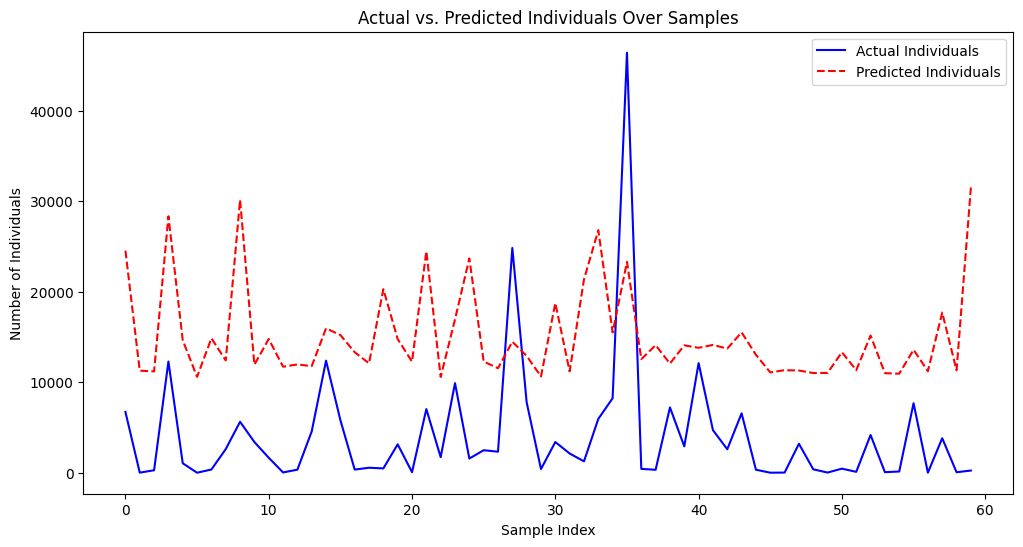


Sample Predictions:
Actual: 6725.00, Predicted: 24550.07
Actual: 16.00, Predicted: 11285.45
Actual: 279.00, Predicted: 11204.60
Actual: 12299.00, Predicted: 28352.22
Actual: 1052.00, Predicted: 14649.00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 200
num_layers = 2
output_size = 1
num_epochs = 300
learning_rate = 1e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving MERGEF.xlsx to MERGEF.xlsx


In [ ]:
import pandas as pd
file_path = "/content/MERGEF.xlsx"  # Adjust path if needed
df= pd.read_excel(file_path)
print(df.columns)

Index(['year', 'month', 'latitude', 'longitude', 'Price', 'precipitation',
       'individuals', 'goldsteinscore'],
      dtype='object')


Epoch 0, Loss: 8.7353
Epoch 10, Loss: 8.3008
Epoch 20, Loss: 8.2619
Epoch 30, Loss: 8.2284
Epoch 40, Loss: 8.2464
Epoch 50, Loss: 8.0681
Epoch 60, Loss: 8.0875
Epoch 70, Loss: 7.8939
Epoch 80, Loss: 7.8864
Epoch 90, Loss: 7.8552
Epoch 100, Loss: 7.9053
Epoch 110, Loss: 7.7783
Epoch 120, Loss: 7.7554
Epoch 130, Loss: 7.6109
Epoch 140, Loss: 7.6969
Epoch 150, Loss: 7.6064
Epoch 160, Loss: 7.4601
Epoch 170, Loss: 7.5899
Epoch 180, Loss: 7.3184
Epoch 190, Loss: 7.5852
Epoch 200, Loss: 7.5957
Epoch 210, Loss: 7.3841
Epoch 220, Loss: 7.3055
Epoch 230, Loss: 7.3848
Epoch 240, Loss: 7.4511
Epoch 250, Loss: 7.2958
Epoch 260, Loss: 7.0973
Epoch 270, Loss: 7.2367
Epoch 280, Loss: 7.1098
Epoch 290, Loss: 7.1726
Epoch 300, Loss: 7.1163
Epoch 310, Loss: 6.9835
Epoch 320, Loss: 7.0529
Epoch 330, Loss: 6.8878
Epoch 340, Loss: 6.9724
Epoch 350, Loss: 6.8794
Epoch 360, Loss: 6.8275
Epoch 370, Loss: 6.8905
Epoch 380, Loss: 6.7609
Epoch 390, Loss: 6.7426
Epoch 400, Loss: 6.7582
Epoch 410, Loss: 6.6692
Epo

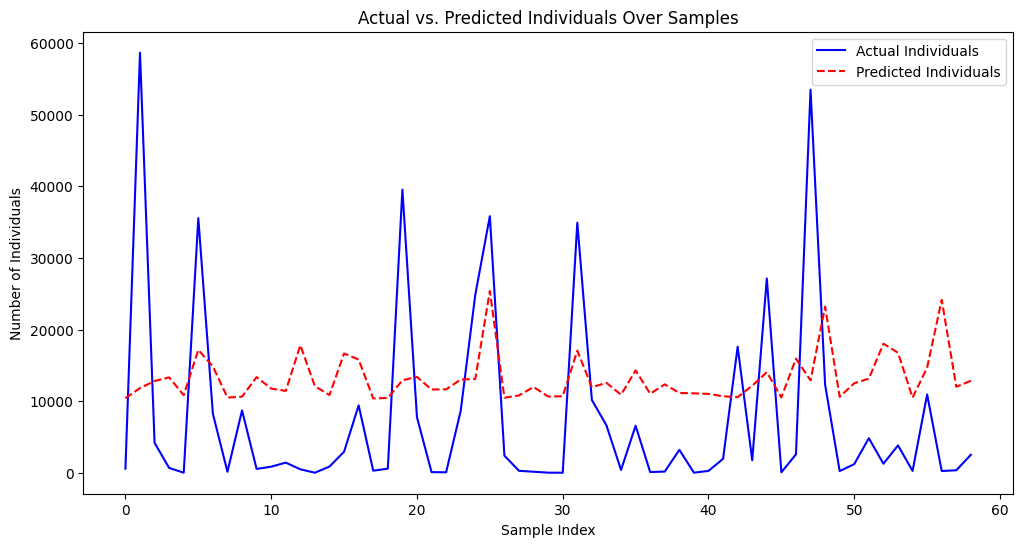


Sample Predictions:
Actual: 575.00, Predicted: 10416.27
Actual: 58649.00, Predicted: 11828.92
Actual: 4180.00, Predicted: 12814.67
Actual: 678.00, Predicted: 13315.92
Actual: 16.00, Predicted: 10837.97


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 8.5313
Epoch 10, Loss: 8.3205
Epoch 20, Loss: 8.3023
Epoch 30, Loss: 7.9615
Epoch 40, Loss: 7.8799
Epoch 50, Loss: 7.7630
Epoch 60, Loss: 7.9442
Epoch 70, Loss: 7.6985
Epoch 80, Loss: 7.6938
Epoch 90, Loss: 7.7172
Epoch 100, Loss: 7.5615
Epoch 110, Loss: 7.5634
Epoch 120, Loss: 7.7512
Epoch 130, Loss: 7.5142
Epoch 140, Loss: 7.4583
Epoch 150, Loss: 7.3950
Epoch 160, Loss: 7.2890
Epoch 170, Loss: 7.4267
Epoch 180, Loss: 7.2560
Epoch 190, Loss: 7.3317
Epoch 200, Loss: 7.4278
Epoch 210, Loss: 7.2661
Epoch 220, Loss: 7.1877
Epoch 230, Loss: 7.0545
Epoch 240, Loss: 7.0458
Epoch 250, Loss: 6.9793
Epoch 260, Loss: 7.1404
Epoch 270, Loss: 7.0642
Epoch 280, Loss: 7.0451
Epoch 290, Loss: 6.9296
Epoch 300, Loss: 6.8617
Epoch 310, Loss: 6.8430
Epoch 320, Loss: 6.8138
Epoch 330, Loss: 6.7784
Epoch 340, Loss: 6.9145
Epoch 350, Loss: 6.6812
Epoch 360, Loss: 6.6591
Epoch 370, Loss: 6.6177
Epoch 380, Loss: 6.7845
Epoch 390, Loss: 6.5784
Epoch 400, Loss: 6.4920
Epoch 410, Loss: 6.4829
Epo

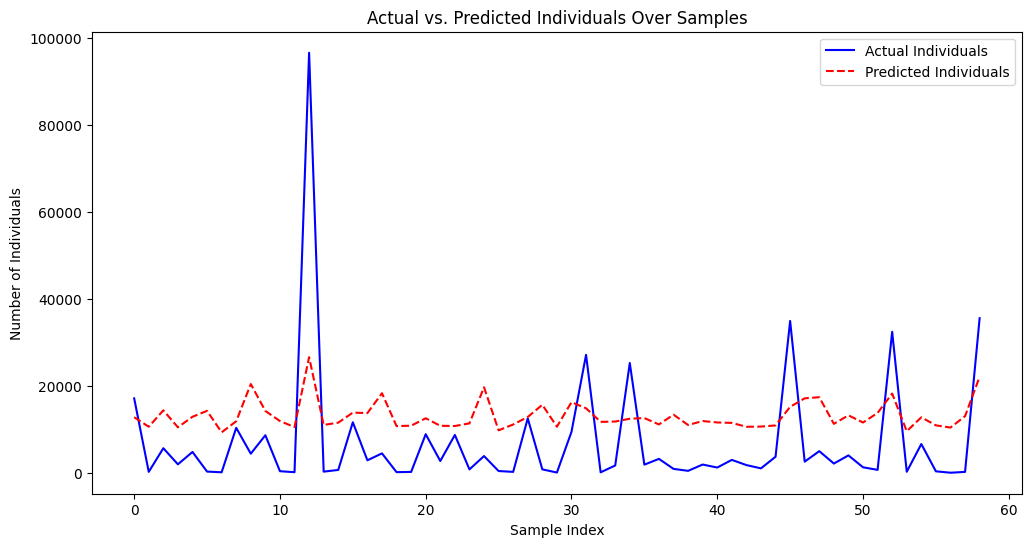


Sample Predictions:
Actual: 17122.00, Predicted: 12776.79
Actual: 219.00, Predicted: 10593.33
Actual: 5660.00, Predicted: 14363.56
Actual: 1953.00, Predicted: 10470.40
Actual: 4799.00, Predicted: 12886.31


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinScore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅
 Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 8.3004
Epoch 10, Loss: 7.9239
Epoch 20, Loss: 7.9938
Epoch 30, Loss: 7.9150
Epoch 40, Loss: 8.0272
Epoch 50, Loss: 7.7670
Epoch 60, Loss: 7.6625
Epoch 70, Loss: 7.4677
Epoch 80, Loss: 7.6249
Epoch 90, Loss: 7.4405
Epoch 100, Loss: 7.3670
Epoch 110, Loss: 7.5456
Epoch 120, Loss: 7.6508
Epoch 130, Loss: 7.3194
Epoch 140, Loss: 7.2804
Epoch 150, Loss: 7.2002
Epoch 160, Loss: 7.1930
Epoch 170, Loss: 7.2971
Epoch 180, Loss: 7.0911
Epoch 190, Loss: 7.0971
Epoch 200, Loss: 7.1456
Epoch 210, Loss: 7.1889
Epoch 220, Loss: 7.0945
Epoch 230, Loss: 7.0669
Epoch 240, Loss: 7.1510
Epoch 250, Loss: 6.9578
Epoch 260, Loss: 6.9699
Epoch 270, Loss: 6.7530
Epoch 280, Loss: 6.7845
Epoch 290, Loss: 6.7603
Epoch 300, Loss: 6.8909
Epoch 310, Loss: 6.7527
Epoch 320, Loss: 6.7885
Epoch 330, Loss: 6.7488
Epoch 340, Loss: 6.6090
Epoch 350, Loss: 6.5282
Epoch 360, Loss: 6.4691
Epoch 370, Loss: 6.5308
Epoch 380, Loss: 6.5994
Epoch 390, Loss: 6.5561
Epoch 400, Loss: 6.4190
Epoch 410, Loss: 6.3064
Epo

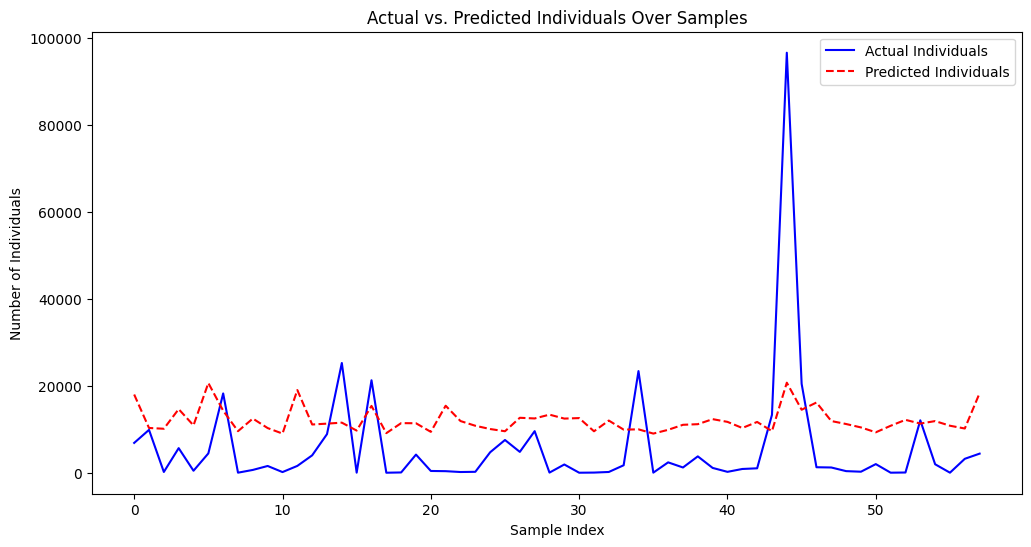


Sample Predictions:
Actual: 6863.00, Predicted: 17994.98
Actual: 9864.00, Predicted: 10299.81
Actual: 181.00, Predicted: 10118.48
Actual: 5660.00, Predicted: 14628.95
Actual: 462.00, Predicted: 10895.55


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinScore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 8.0438
Epoch 10, Loss: 7.6762
Epoch 20, Loss: 7.6437
Epoch 30, Loss: 7.6426
Epoch 40, Loss: 7.5678
Epoch 50, Loss: 7.3857
Epoch 60, Loss: 7.3966
Epoch 70, Loss: 7.3277
Epoch 80, Loss: 7.1638
Epoch 90, Loss: 7.2238
Epoch 100, Loss: 7.1930
Epoch 110, Loss: 7.1097
Epoch 120, Loss: 7.0217
Epoch 130, Loss: 7.0522
Epoch 140, Loss: 7.0031
Epoch 150, Loss: 6.8803
Epoch 160, Loss: 6.9613
Epoch 170, Loss: 6.8430
Epoch 180, Loss: 6.8324
Epoch 190, Loss: 6.6941
Epoch 200, Loss: 6.8060
Epoch 210, Loss: 6.6152
Epoch 220, Loss: 6.7092
Epoch 230, Loss: 6.7458
Epoch 240, Loss: 6.6114
Epoch 250, Loss: 6.6760
Epoch 260, Loss: 6.6589
Epoch 270, Loss: 6.4923
Epoch 280, Loss: 6.6211
Epoch 290, Loss: 6.7449
Epoch 300, Loss: 6.4825
Epoch 310, Loss: 6.4157
Epoch 320, Loss: 6.4620
Epoch 330, Loss: 6.3331
Epoch 340, Loss: 6.3462
Epoch 350, Loss: 6.4349
Epoch 360, Loss: 6.5182
Epoch 370, Loss: 6.2979
Epoch 380, Loss: 6.1899
Epoch 390, Loss: 6.4185
Epoch 400, Loss: 6.0787
Epoch 410, Loss: 6.1838
Epo

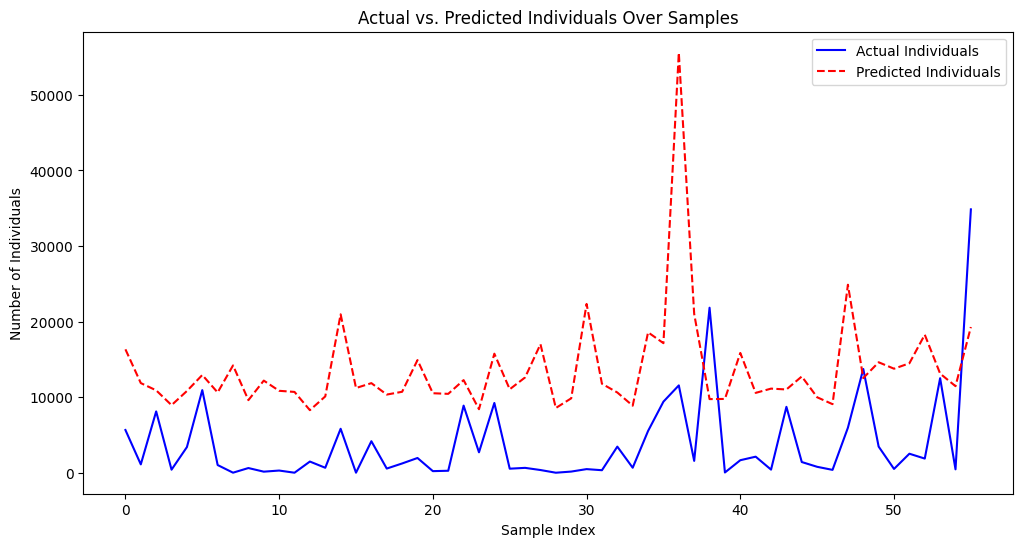


Sample Predictions:
Actual: 5660.00, Predicted: 16334.76
Actual: 1111.00, Predicted: 11866.67
Actual: 8118.00, Predicted: 10907.24
Actual: 410.00, Predicted: 8948.02
Actual: 3399.00, Predicted: 10819.50


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinScore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 8.4872
Epoch 10, Loss: 8.8825
Epoch 20, Loss: 8.5103
Epoch 30, Loss: 8.6766
Epoch 40, Loss: 8.2876
Epoch 50, Loss: 8.5978
Epoch 60, Loss: 8.4536
Epoch 70, Loss: 9.3058
Epoch 80, Loss: 8.4791
Epoch 90, Loss: 8.6470
Epoch 100, Loss: 8.1868
Epoch 110, Loss: 8.5731
Epoch 120, Loss: 8.4032
Epoch 130, Loss: 8.5221
Epoch 140, Loss: 8.4075
Epoch 150, Loss: 8.4688
Epoch 160, Loss: 8.4553
Epoch 170, Loss: 8.4741
Epoch 180, Loss: 8.2689
Epoch 190, Loss: 8.4703
Epoch 200, Loss: 8.6113
Epoch 210, Loss: 9.2165
Epoch 220, Loss: 8.5274
Epoch 230, Loss: 8.5637
Epoch 240, Loss: 8.7408
Epoch 250, Loss: 8.5068
Epoch 260, Loss: 8.5297
Epoch 270, Loss: 8.4846
Epoch 280, Loss: 8.2620
Epoch 290, Loss: 8.3392
Epoch 300, Loss: 8.3827
Epoch 310, Loss: 9.0136
Epoch 320, Loss: 8.4053
Epoch 330, Loss: 8.3898
Epoch 340, Loss: 8.4380
Epoch 350, Loss: 8.3435
Epoch 360, Loss: 8.3397
Epoch 370, Loss: 8.5814
Epoch 380, Loss: 8.3676
Epoch 390, Loss: 8.2106
Epoch 400, Loss: 8.4069
Epoch 410, Loss: 8.3817
Epo

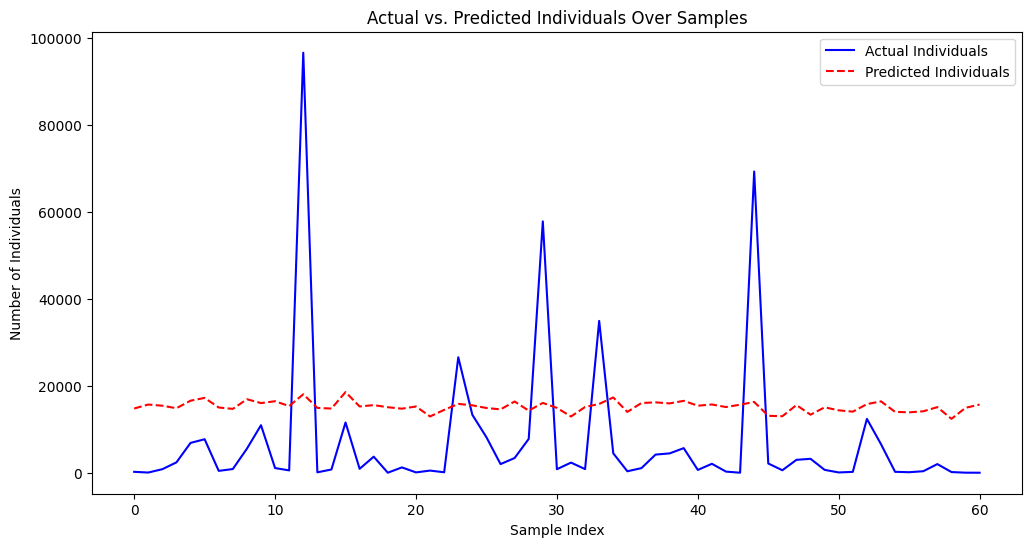


Sample Predictions:
Actual: 210.00, Predicted: 14773.30
Actual: 49.00, Predicted: 15689.44
Actual: 818.00, Predicted: 15413.70
Actual: 2389.00, Predicted: 14843.42
Actual: 6863.00, Predicted: 16568.82


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinScore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 8.4827
Epoch 10, Loss: 8.6316
Epoch 20, Loss: 8.1789
Epoch 30, Loss: 8.2555
Epoch 40, Loss: 7.7650
Epoch 50, Loss: 8.1308
Epoch 60, Loss: 7.9537
Epoch 70, Loss: 8.6662
Epoch 80, Loss: 7.8157
Epoch 90, Loss: 7.9500
Epoch 100, Loss: 7.4820
Epoch 110, Loss: 7.7311
Epoch 120, Loss: 7.6217
Epoch 130, Loss: 7.6155
Epoch 140, Loss: 7.5816
Epoch 150, Loss: 7.5624
Epoch 160, Loss: 7.5300
Epoch 170, Loss: 7.4992
Epoch 180, Loss: 7.2490
Epoch 190, Loss: 7.4228
Epoch 200, Loss: 7.5416
Epoch 210, Loss: 8.1148
Epoch 220, Loss: 7.3450
Epoch 230, Loss: 7.4564
Epoch 240, Loss: 7.3937
Epoch 250, Loss: 7.3140
Epoch 260, Loss: 7.2855
Epoch 270, Loss: 7.1800
Epoch 280, Loss: 6.9575
Epoch 290, Loss: 6.9809
Epoch 300, Loss: 6.8837
Epoch 310, Loss: 7.6834
Epoch 320, Loss: 6.9782
Epoch 330, Loss: 6.8846
Epoch 340, Loss: 6.8979
Epoch 350, Loss: 6.8600
Epoch 360, Loss: 6.6486
Epoch 370, Loss: 6.8627
Epoch 380, Loss: 6.6164
Epoch 390, Loss: 6.4257
Epoch 400, Loss: 6.6664
Epoch 410, Loss: 6.5490
Epo

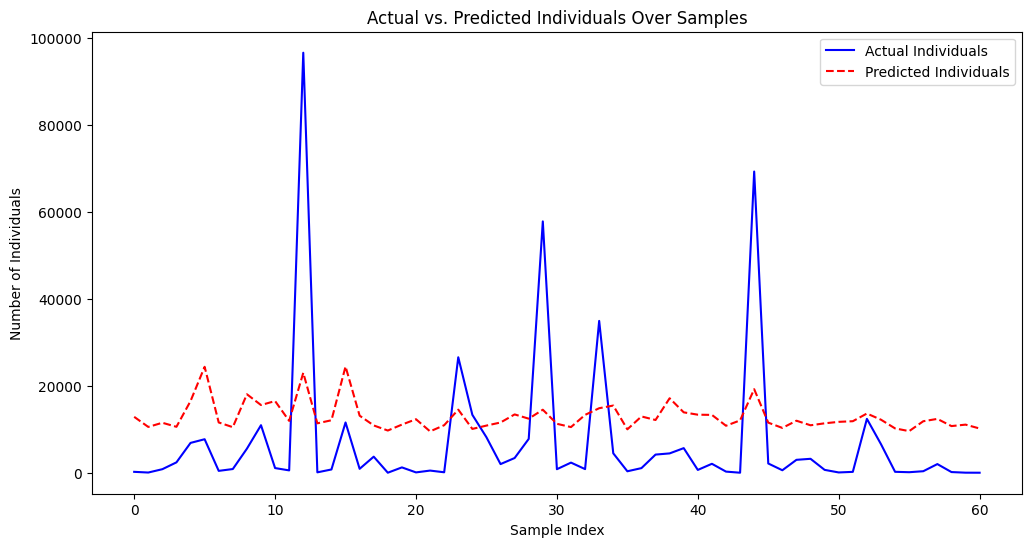


Sample Predictions:
Actual: 210.00, Predicted: 12858.40
Actual: 49.00, Predicted: 10537.06
Actual: 818.00, Predicted: 11496.42
Actual: 2389.00, Predicted: 10568.75
Actual: 6863.00, Predicted: 16489.18


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinScore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 6.1580
Epoch 10, Loss: 4.2087
Epoch 20, Loss: 4.0990
Epoch 30, Loss: 4.0566
Epoch 40, Loss: 4.0247
Epoch 50, Loss: 3.9207
Epoch 60, Loss: 3.7550
Epoch 70, Loss: 3.7263
Epoch 80, Loss: 3.6091
Epoch 90, Loss: 3.7177
Epoch 100, Loss: 3.6439
Epoch 110, Loss: 3.5102
Epoch 120, Loss: 3.5991
Epoch 130, Loss: 3.5889
Epoch 140, Loss: 3.4632
Epoch 150, Loss: 3.4607
Epoch 160, Loss: 3.5100
Epoch 170, Loss: 3.3934
Epoch 180, Loss: 3.4331
Epoch 190, Loss: 3.2625
Epoch 200, Loss: 3.2173
Epoch 210, Loss: 3.2435
Epoch 220, Loss: 3.1971
Epoch 230, Loss: 3.1944
Epoch 240, Loss: 3.0799
Epoch 250, Loss: 2.9840
Epoch 260, Loss: 2.9277
Epoch 270, Loss: 3.0263
Epoch 280, Loss: 3.0800
Epoch 290, Loss: 3.2091
Epoch 300, Loss: 3.0383
Epoch 310, Loss: 3.0887
Epoch 320, Loss: 3.0009
Epoch 330, Loss: 3.2633
Epoch 340, Loss: 3.0755
Epoch 350, Loss: 3.1036
Epoch 360, Loss: 2.9919
Epoch 370, Loss: 2.9467
Epoch 380, Loss: 2.9765
Epoch 390, Loss: 2.9177
Epoch 400, Loss: 2.9897
Epoch 410, Loss: 2.9445
Epo

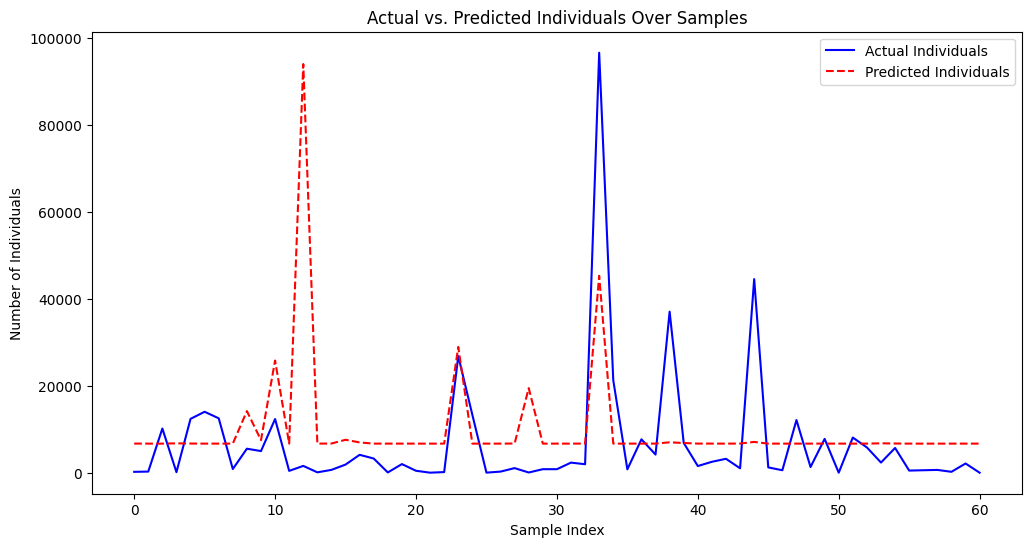


Sample Predictions:
Actual: 210.00, Predicted: 6707.77
Actual: 268.00, Predicted: 6697.29
Actual: 10170.00, Predicted: 6698.13
Actual: 131.00, Predicted: 6756.83
Actual: 12391.00, Predicted: 6717.18


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.norm = nn.LayerNorm(hidden_size)  # ✅ Use LayerNorm instead of BatchNorm
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softplus()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 150  # ✅ Reduced from 300 to 150
num_layers = 3
output_size = 1
num_epochs = 500
learning_rate = 5e-5  # ✅ Increased from 5e-6 to 5e-5

# ✅ Choose Optimizer (Switch easily)
optimizer_choice = "AdamW"

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()

if optimizer_choice == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
elif optimizer_choice == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_choice == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)
else:
    raise ValueError("Invalid optimizer choice. Use 'AdamW', 'Adam', or 'RMSprop'.")

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # ✅ Gradient Clipping
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 4.6988
Epoch 10, Loss: 4.3821
Epoch 20, Loss: 4.3474
Epoch 30, Loss: 4.1448
Epoch 40, Loss: 4.1142
Epoch 50, Loss: 4.0063
Epoch 60, Loss: 4.0406
Epoch 70, Loss: 4.0296
Epoch 80, Loss: 4.0848
Epoch 90, Loss: 3.9039
Epoch 100, Loss: 4.0999
Epoch 110, Loss: 4.0040
Epoch 120, Loss: 3.9674
Epoch 130, Loss: 4.1313
Epoch 140, Loss: 3.9663
Epoch 150, Loss: 4.1226
Epoch 160, Loss: 3.9270
Epoch 170, Loss: 4.0150
Epoch 180, Loss: 3.9704
Epoch 190, Loss: 4.0266
Epoch 200, Loss: 3.9356
Epoch 210, Loss: 3.8765
Epoch 220, Loss: 3.8184
Epoch 230, Loss: 3.8566
Epoch 240, Loss: 4.0762
Epoch 250, Loss: 3.9999
Epoch 260, Loss: 3.9454
Epoch 270, Loss: 3.9429
Epoch 280, Loss: 3.9765
Epoch 290, Loss: 3.9919
Epoch 300, Loss: 3.8345
Epoch 310, Loss: 4.0323
Epoch 320, Loss: 4.0705
Epoch 330, Loss: 4.0347
Epoch 340, Loss: 4.0211
Epoch 350, Loss: 4.0910
Epoch 360, Loss: 3.9761
Epoch 370, Loss: 4.0409
Epoch 380, Loss: 3.9721
Epoch 390, Loss: 3.8527
Epoch 400, Loss: 3.9623
Epoch 410, Loss: 4.0680
Epo

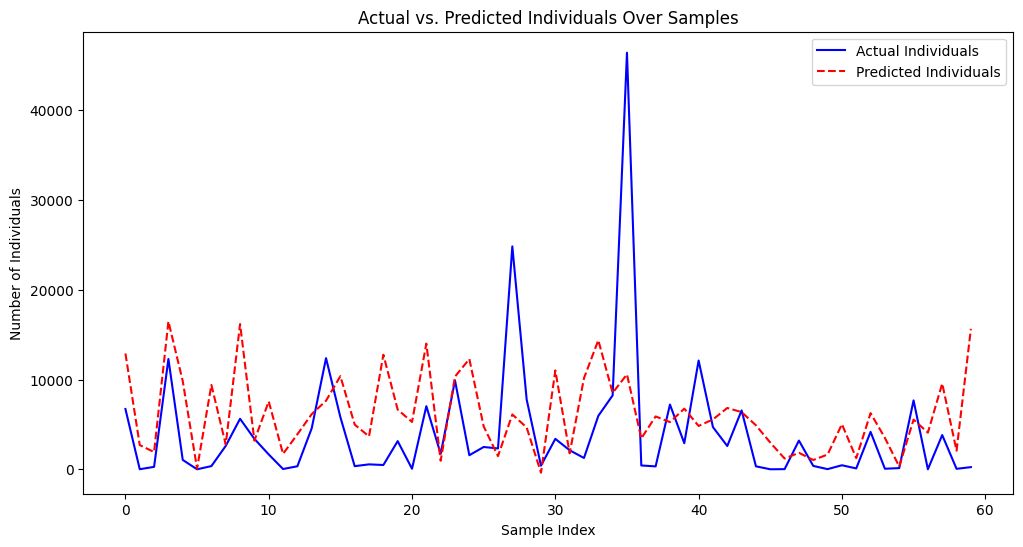


Sample Predictions:
Actual: 6725.00, Predicted: 12912.22
Actual: 16.00, Predicted: 2705.54
Actual: 279.00, Predicted: 1927.16
Actual: 12299.00, Predicted: 16483.05
Actual: 1052.00, Predicted: 9831.43


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 300
num_layers = 3
output_size = 1
num_epochs = 700
learning_rate = 5e-6

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-6, weight_decay=1e-5)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 3.8482
Epoch 10, Loss: 3.8232
Epoch 20, Loss: 3.7668
Epoch 30, Loss: 3.6385
Epoch 40, Loss: 3.5610
Epoch 50, Loss: 3.6540
Epoch 60, Loss: 3.5947
Epoch 70, Loss: 3.5121
Epoch 80, Loss: 3.5582
Epoch 90, Loss: 3.5932
Epoch 100, Loss: 3.6705
Epoch 110, Loss: 3.5744
Epoch 120, Loss: 3.5544
Epoch 130, Loss: 3.5813
Epoch 140, Loss: 3.4808
Epoch 150, Loss: 3.5652
Epoch 160, Loss: 3.6679
Epoch 170, Loss: 3.4910
Epoch 180, Loss: 3.5851
Epoch 190, Loss: 3.5259
Epoch 200, Loss: 3.5552
Epoch 210, Loss: 3.4475
Epoch 220, Loss: 3.5214
Epoch 230, Loss: 3.4922
Epoch 240, Loss: 3.4335
Epoch 250, Loss: 3.6456
Epoch 260, Loss: 3.5858
Epoch 270, Loss: 3.5333
Epoch 280, Loss: 3.4942
Epoch 290, Loss: 3.5192
Epoch 300, Loss: 3.5150
Epoch 310, Loss: 3.5272
Epoch 320, Loss: 3.4727
Epoch 330, Loss: 3.5086
Epoch 340, Loss: 3.4996
Epoch 350, Loss: 3.4607
Epoch 360, Loss: 3.5251
Epoch 370, Loss: 3.5186
Epoch 380, Loss: 3.6216
Epoch 390, Loss: 3.4564
Epoch 400, Loss: 3.5222
Epoch 410, Loss: 3.5852
Epo

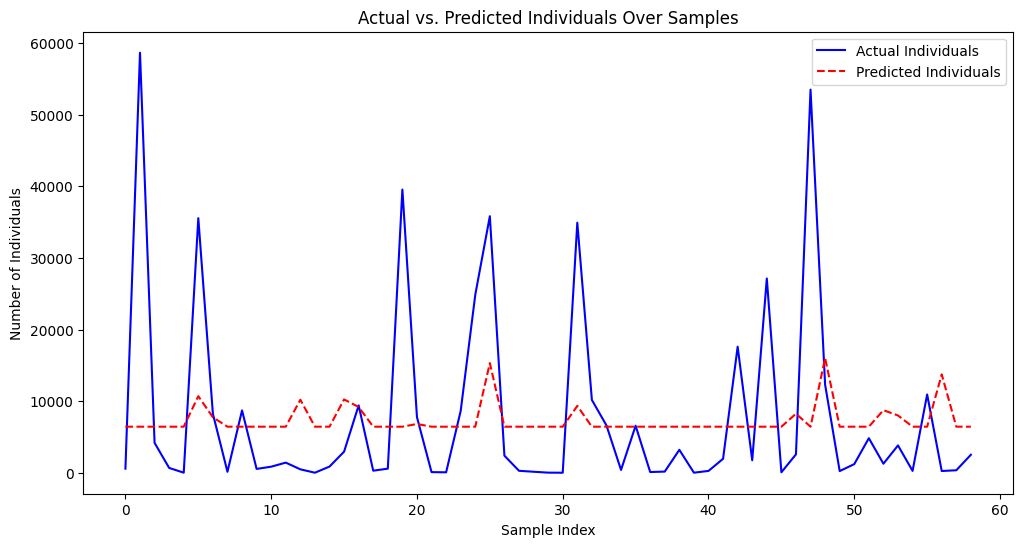


Sample Predictions:
Actual: 575.00, Predicted: 6436.85
Actual: 58649.00, Predicted: 6436.85
Actual: 4180.00, Predicted: 6436.85
Actual: 678.00, Predicted: 6436.85
Actual: 16.00, Predicted: 6436.85


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 400
num_layers = 4
output_size = 1
num_epochs = 1000
learning_rate = 1e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-6, weight_decay=1e-6)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, verbose=True)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 13.0003
Epoch 10, Loss: 13.7331
Epoch 20, Loss: 10.9093
Epoch 30, Loss: 10.2883
Epoch 40, Loss: 10.0933
Epoch 50, Loss: 9.6625
Epoch 60, Loss: 9.3383
Epoch 70, Loss: 9.3818
Epoch 80, Loss: 9.4702
Epoch 90, Loss: 9.3527
Epoch 100, Loss: 9.0072
Epoch 110, Loss: 8.9281
Epoch 120, Loss: 8.9075
Epoch 130, Loss: 8.9182
Epoch 140, Loss: 8.6329
Epoch 150, Loss: 8.7382
Epoch 160, Loss: 8.8453
Epoch 170, Loss: 8.9170
Epoch 180, Loss: 8.9877
Epoch 190, Loss: 8.3588
Epoch 200, Loss: 8.3204
Epoch 210, Loss: 7.9778
Epoch 220, Loss: 7.7009
Epoch 230, Loss: 7.7851
Epoch 240, Loss: 7.8691
Epoch 250, Loss: 7.5262
Epoch 260, Loss: 7.4999
Epoch 270, Loss: 7.4934
Epoch 280, Loss: 7.2982
Epoch 290, Loss: 7.1744
Epoch 300, Loss: 7.0487
Epoch 310, Loss: 6.9946
Epoch 320, Loss: 6.4739
Epoch 330, Loss: 6.6117
Epoch 340, Loss: 6.0115
Epoch 350, Loss: 5.6873
Epoch 360, Loss: 6.2191
Epoch 370, Loss: 5.4560
Epoch 380, Loss: 5.5992
Epoch 390, Loss: 5.2654
Epoch 400, Loss: 5.6356
Epoch 410, Loss: 5.117

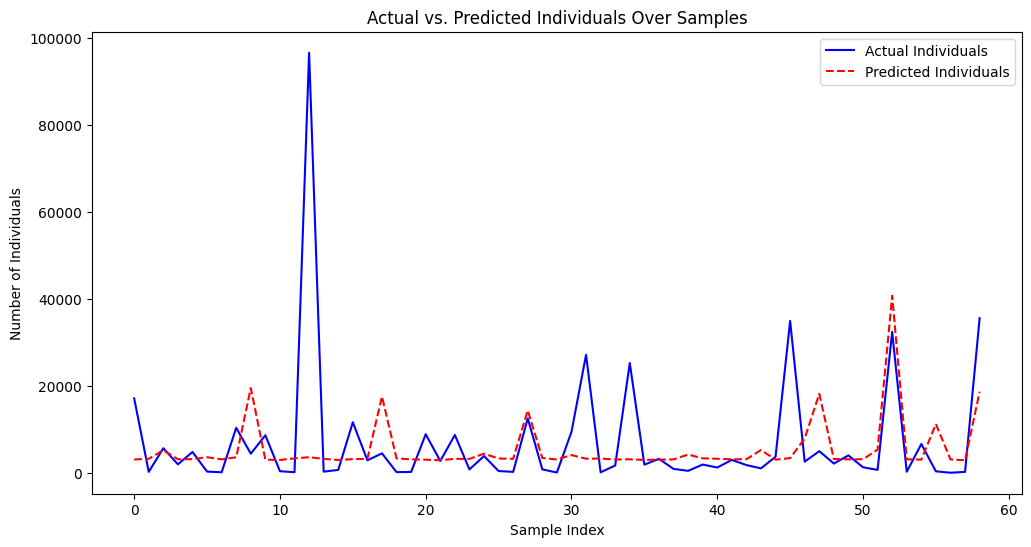


Sample Predictions:
Actual: 17122.00, Predicted: 3069.47
Actual: 219.00, Predicted: 3231.61
Actual: 5660.00, Predicted: 5189.76
Actual: 1953.00, Predicted: 3116.69
Actual: 4799.00, Predicted: 3142.20


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 400
num_layers = 4
output_size = 1
num_epochs = 1000
learning_rate = 5e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-6, weight_decay=1e-6)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, verbose=True)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


Epoch 0, Loss: 4.4732
Epoch 10, Loss: 3.5068
Epoch 20, Loss: 3.6048
Epoch 30, Loss: 3.5226
Epoch 40, Loss: 3.5584
Epoch 50, Loss: 3.5028
Epoch 60, Loss: 3.4932
Epoch 70, Loss: 3.4172
Epoch 80, Loss: 3.4422
Epoch 90, Loss: 3.4095
Epoch 100, Loss: 3.4137
Epoch 110, Loss: 3.3964
Epoch 120, Loss: 3.4198
Epoch 130, Loss: 3.4219
Epoch 140, Loss: 3.4483
Epoch 150, Loss: 3.3804
Epoch 160, Loss: 3.3853
Epoch 170, Loss: 3.4017
Epoch 180, Loss: 3.3546
Epoch 190, Loss: 3.3964
Epoch 200, Loss: 3.3779
Epoch 210, Loss: 3.3985
Epoch 220, Loss: 3.3943
Epoch 230, Loss: 3.4047
Epoch 240, Loss: 3.3961
Epoch 250, Loss: 3.4038
Epoch 260, Loss: 3.4237
Epoch 270, Loss: 3.4103
Epoch 280, Loss: 3.4215
Epoch 290, Loss: 3.4416
Epoch 300, Loss: 3.3930
Epoch 310, Loss: 3.4083
Epoch 320, Loss: 3.3675
Epoch 330, Loss: 3.4180
Epoch 340, Loss: 3.4215
Epoch 350, Loss: 3.4565
Epoch 360, Loss: 3.3829
Epoch 370, Loss: 3.4931
Epoch 380, Loss: 3.3233
Epoch 390, Loss: 3.4055
Epoch 400, Loss: 3.3706
Epoch 410, Loss: 3.4194
Epo

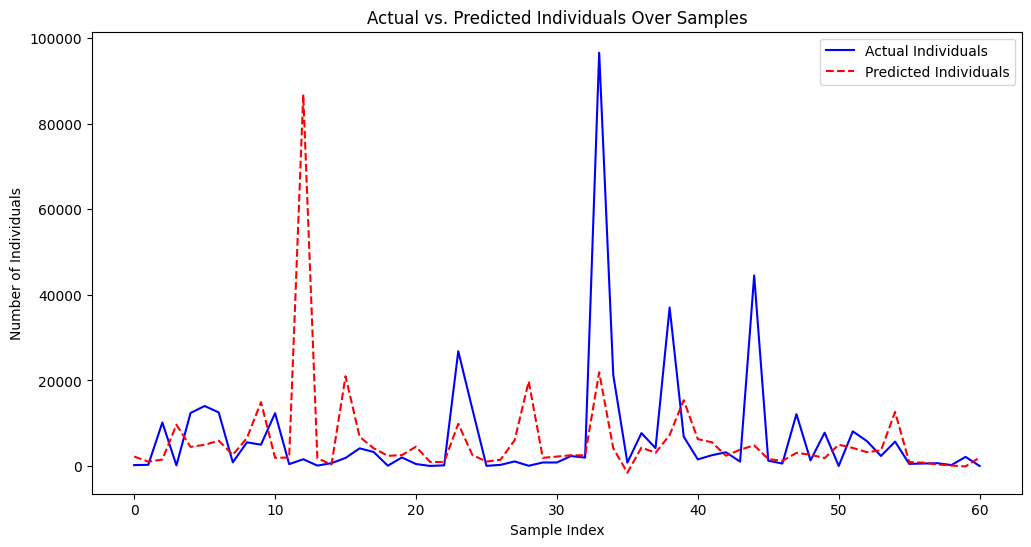


Sample Predictions:
Actual: 210.00, Predicted: 2210.31
Actual: 268.00, Predicted: 1007.18
Actual: 10170.00, Predicted: 1501.20
Actual: 131.00, Predicted: 9653.15
Actual: 12391.00, Predicted: 4465.94


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)


# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.norm = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = self.norm(torch.mean(lstm_out, dim=1))  # Apply normalization
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 500
num_layers = 4
output_size = 1
num_epochs = 1200  # Increased epochs
learning_rate = 5e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)


# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.norm = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = self.norm(torch.mean(lstm_out, dim=1))  # Apply normalization
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 500
num_layers = 4
output_size = 1
num_epochs = 1200  # Increased epochs
learning_rate = 5e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))



Epoch 0, Loss: 4.3031
Epoch 10, Loss: 4.2144
Epoch 20, Loss: 3.4247
Epoch 30, Loss: 3.6080
Epoch 40, Loss: 3.3601
Epoch 50, Loss: 4.3771
Epoch 60, Loss: 3.4280
Epoch 70, Loss: 3.4225
Epoch 80, Loss: 3.8335
Epoch 90, Loss: 3.2268
Epoch 100, Loss: 3.2949
Epoch 110, Loss: 3.9912
Epoch 120, Loss: 3.1554
Epoch 130, Loss: 3.2295
Epoch 140, Loss: 3.1668
Epoch 150, Loss: 3.2604
Epoch 160, Loss: 3.1777
Epoch 170, Loss: 3.1885
Epoch 180, Loss: 4.2454
Epoch 190, Loss: 3.2972
Epoch 200, Loss: 3.3844
Epoch 210, Loss: 3.1967
Epoch 220, Loss: 3.1928
Epoch 230, Loss: 3.5789
Epoch 240, Loss: 3.1295
Epoch 250, Loss: 3.1857
Epoch 260, Loss: 3.2424
Epoch 270, Loss: 3.3829
Epoch 280, Loss: 3.1866
Epoch 290, Loss: 3.2787
Epoch 300, Loss: 3.5893
Epoch 310, Loss: 3.2390
Epoch 320, Loss: 3.2025
Epoch 330, Loss: 3.2367
Epoch 340, Loss: 3.3771
Epoch 350, Loss: 3.2745
Epoch 360, Loss: 3.1943
Epoch 370, Loss: 3.1692
Epoch 380, Loss: 3.2641
Epoch 390, Loss: 3.2229
Epoch 400, Loss: 3.3046
Epoch 410, Loss: 3.2237
Epo

#PREDICTION CODE

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Helper to step through months
def next_month_year(month, year, steps):
    date = datetime(year, month, 1) + relativedelta(months=steps)
    return date.month, date.year

# Get unique (lat, lon) pairs
unique_locations = df[['latitude', 'longitude']].drop_duplicates()

# Results list
forecast_results = []

# Loop over locations
for _, loc in unique_locations.iterrows():
    lat, lon = loc['latitude'], loc['longitude']

    # Subset for the latest available data for this location
    subset = df[(df['latitude'] == lat) & (df['longitude'] == lon)].sort_values(by=['year', 'month'])
    if subset.empty:
        continue

    last_row = subset.iloc[-1]

    # Extract latest lag values
    lag_buffer = {
        f'Price_lag{i}': last_row[f'Price_lag{i}'] for i in range(1, lags + 1)
    }

    for i in range(1, lags + 1):
        lag_buffer[f'individuals_lag{i}'] = last_row[f'individuals_lag{i}']
        lag_buffer[f'precipitation_lag{i}'] = last_row[f'precipitation_lag{i}']

    current_month = int(last_row['month'])
    current_year = int(last_row['year'])

    for step in range(1, 25):  # Predict next 24 months
        next_m, next_y = next_month_year(current_month, current_year, step)

        # Build input vector
        input_features = [next_m, next_y, lat, lon] + \
                         [lag_buffer[f'Price_lag{i}'] for i in range(1, lags + 1)] + \
                         [lag_buffer[f'individuals_lag{i}'] for i in range(1, lags + 1)] + \
                         [lag_buffer[f'precipitation_lag{i}'] for i in range(1, lags + 1)]

        # Scale input
        X_future = scaler_X.transform([input_features])
        X_tensor = torch.tensor(X_future, dtype=torch.float32)

        # Predict
        with torch.no_grad():
            y_future_pred = model(X_tensor).numpy()
        y_future_pred_rescaled = scaler_y.inverse_transform(y_future_pred)[0][0]

        # Save result
        forecast_results.append({
            'latitude': lat,
            'longitude': lon,
            'month': next_m,
            'year': next_y,
            'predicted_individuals': y_future_pred_rescaled
        })

        # Update lag buffer (slide window)
        for i in range(lags, 1, -1):
            lag_buffer[f'individuals_lag{i}'] = lag_buffer[f'individuals_lag{i - 1}']
        lag_buffer['individuals_lag1'] = y_future_pred_rescaled

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_results)


In [ ]:
forecast_df.head()

,latitude,longitude,month,year,predicted_individuals
0,17.62787,23.737268,4,2011,6474.453613
1,17.62787,23.737268,5,2011,9686.886719
2,17.62787,23.737268,6,2011,7096.824219
3,17.62787,23.737268,7,2011,6945.889160
4,17.62787,23.737268,8,2011,7940.540039


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 12.5229
Epoch 10, Loss: 12.1759
Epoch 20, Loss: 10.0661
Epoch 30, Loss: 9.6223
Epoch 40, Loss: 13.8478
Epoch 50, Loss: 8.9465
Epoch 60, Loss: 8.9644
Epoch 70, Loss: 8.7134
Epoch 80, Loss: 8.5189
Epoch 90, Loss: 8.2962
Epoch 100, Loss: 8.3725
Epoch 110, Loss: 9.3573
Epoch 120, Loss: 8.5987
Epoch 130, Loss: 8.4114
Epoch 140, Loss: 9.4040
Epoch 150, Loss: 8.0540
Epoch 160, Loss: 7.6293
Epoch 170, Loss: 10.0882
Epoch 180, Loss: 8.2643
Epoch 190, Loss: 9.8125
Epoch 200, Loss: 7.4772
Epoch 210, Loss: 7.0740
Epoch 220, Loss: 7.4119
Epoch 230, Loss: 7.0024
Epoch 240, Loss: 7.0728
Epoch 250, Loss: 7.3710
Epoch 260, Loss: 6.5911
Epoch 270, Loss: 6.9988
Epoch 280, Loss: 6.6537
Epoch 290, Loss: 6.3311
Epoch 300, Loss: 6.1241
Epoch 310, Loss: 6.0863
Epoch 320, Loss: 6.5242
Epoch 330, Loss: 6.0135
Epoch 340, Loss: 9.4089
Epoch 350, Loss: 6.1092
Epoch 360, Loss: 5.4571
Epoch 370, Loss: 5.4888
Epoch 380, Loss: 5.3883
Epoch 390, Loss: 5.1620
Epoch 400, Loss: 5.8869
Epoch 410, Loss: 5.311

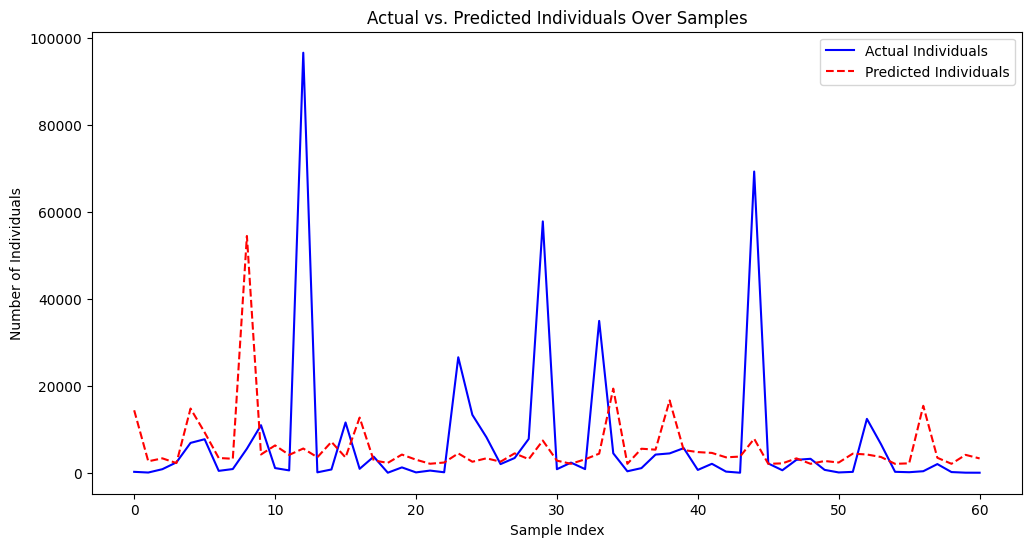


Sample Predictions:
Actual: 210.00, Predicted: 14365.37
Actual: 49.00, Predicted: 2630.73
Actual: 818.00, Predicted: 3312.15
Actual: 2389.00, Predicted: 2224.21
Actual: 6863.00, Predicted: 14765.39


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ✅ Load Data # Assume df is already loaded

# ✅ Define Features and Lags
lags = 3  # Number of lag months to include
features = ["month", "year", "latitude", "longitude", "Price", "individuals", "precipitation", "goldsteinscore"]
target = "individuals"

# Create lagged features
for lag in range(1, lags + 1):
    df[f"Price_lag{lag}"] = df["Price"].shift(lag)
    df[f"individuals_lag{lag}"] = df["individuals"].shift(lag)
    df[f"precipitation_lag{lag}"] = df["precipitation"].shift(lag)
    df[f"goldsteinScore_lag{lag}"] = df["goldsteinscore"].shift(lag)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)

# ✅ Separate Features and Target
new_features = ["month", "year", "latitude", "longitude"] + [f"Price_lag{i}" for i in range(1, lags + 1)] + [f"individuals_lag{i}" for i in range(1, lags + 1)] + [f"precipitation_lag{i}" for i in range(1, lags + 1)] + [f"goldsteinScore_lag{i}" for i in range(1, lags + 1)]
X = df[new_features].values
y = df[[target]].values

# ✅ Feature Scaling
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ✅ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ✅ Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ✅ Define Updated LSTM Model
class SpatioTemporalNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SpatioTemporalNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = torch.mean(lstm_out, dim=1)
        out = self.fc(lstm_out)
        return out

# ✅ Model Parameters
input_size = X_train.shape[1]
hidden_size = 400
num_layers = 4
output_size = 1
num_epochs = 1200
learning_rate = 5e-5

# ✅ Initialize Model
model = SpatioTemporalNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-6, weight_decay=1e-6)

# ✅ Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, verbose=True)

# ✅ Train Model
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# ✅ Make Predictions
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()
    y_pred_test = scaler_y.inverse_transform(y_pred_test)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ✅ Plot Actual vs. Predicted Line Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Individuals", linestyle='-', color='blue')
plt.plot(y_pred_test, label="Predicted Individuals", linestyle='--', color='red')
plt.xlabel("Sample Index")
plt.ylabel("Number of Individuals")
plt.title("Actual vs. Predicted Individuals Over Samples")
plt.legend()
plt.show()

# ✅ Print Sample Predictions
print("\nSample Predictions:")
for i in range(5):  # Print first 5 samples
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred_test[i][0]:.2f}")
